### Task V: Quantum Graph Neural Network (QGNN) 

In task II you already worked with a classical GNN. 
Describe a possibility for a QGNN circuit, which takes advantage of the graph representation of the data.
Implement and draw the circuit.


Firstly, let's do a brief overview of modern Graph Neural Networks:

#### GNN Overview

##### The Message-Passing Process

GNNs rely heavily on the message-passing mechanism to process graph-structured data. This mechanism typically involves:

1. Message Function: This step computes a "message" for each edge in the graph, typically using the features of the source nodes (x_i) and neighbor nodes (x_j). The goal is to capture the information that nodes should share with their neighbors.

2. Aggregate Function: Following message computation, the next step aggregates these messages at each target node. Different aggregation schemes (like sum, mean, or max) determine how messages from various neighbors are combined, shaping the node features for the next layer.

Node feature transformation is often conducted in Multi-Layer Perceptron (MLP) in classical GNNs.  We can instead utilize Parameterized Quantum Circuits (PQCs) to for this task. However, this can be computationally intensive in PQC simulation due to multiple passes over the edges and nodes. 

##### Global Pooling and Classifier

After processing through GNN layers, global pooling aggregates node features across the graph to form a graph-level representation, which is then passed to a classifier for tasks like graph classification or property prediction.  Here too, PQCs could replace classical computations.

To explore the integration of quantum computing with GNNs, we will implement a quantum layer within the message-passing stage. Although this approach may introduce computational challenges, we at least would like to quantify the bottlenecks. 

We will adapt the same dataset and architecture of PointNet defined in Task 2, and modify the network's first graph convolutional layer to be quantum-based. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch_geometric as pyg
import torch_geometric.nn as pyg_nn
import torch_geometric.data as pyg_data
import torch_geometric.loader as pyg_loader
import torch_geometric.transforms as T

import networkx as nx
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os

%matplotlib inline

In [2]:
class QG_Jets(pyg_data.InMemoryDataset):
    def __init__(self, root, version='pid_as_feature', 
                 transform=None, pre_transform=None, pre_filter=None, force_reload=True):
        self.version = version 
        super().__init__(root, transform, pre_transform)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = glob.glob(self.root + '/raw/*.npz') 
        return [file.split('/')[-1] for file in files]

    @property
    def processed_file_names(self):
        if self.version == 'without_pid':
            return ['data_without_pid.pt']
        elif self.version == 'with_pid':
            return ['data_with_pid.pt']
        else:
            raise ValueError("Invalid version specified. Choose 'without_pid' or 'with_pid'.")

    def download(self) -> None:
        pass  # Assuming data is already downloaded

    def process(self):
        
        data_list = []
        print(self.raw_paths)
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            data = np.load(raw_path)

            # Access the arrays stored in the NPZ file
            pcs = data['X']
            ys = data['y']  
            
            # PDGid to float dictionary
            PID2FLOAT_MAP = {22: 0,
                 211: .1, -211: .2,
                 321: .3, -321: .4,
                 130: .5,
                 2112: .6, -2112: .7,
                 2212: .8, -2212: .9,
                 11: 1.0, -11: 1.1,
                 13: 1.2, -13: 1.3,
                 0: 1.5,  # Representing undefined PID
                 }
            
            pids = np.unique(pcs[:, :, 3]).flatten()
            print("PIDS:", pids)
            for index, pc in enumerate(pcs):
                # Remove zero-padding
                pc = pc[~np.all(pc == 0, axis=1)]
                
                pt_total = np.sum(pc[:, 0])  # Total scalar sum of p_T
                
                # Center y and phi
                weighted_y = np.sum(pc[:, 0] * pc[:, 1]) / pt_total
                weighted_phi = np.sum(pc[:, 0] * pc[:, 2]) / pt_total
                pc[:, 1] = pc[:, 1] - weighted_y
                pc[:, 2] = pc[:, 2] - weighted_phi
                
                # Normalize p_T
                pc[:, 0] = pc[:, 0] / pt_total
            
                for pid in pids:
                    np.place(pc[:, 3], pc[:, 3] == pid, PID2FLOAT_MAP[pid])
            
                if self.version == 'without_pid':
                    data = pyg_data.Data(x = torch.tensor(pc[:, :3], 
                                               dtype=torch.float), 
                                         pos = torch.tensor(pc[:, :3], 
                                               dtype=torch.float),
                                         y=int(ys[index]))
                elif self.version == 'with_pid':
                    data = pyg_data.Data(x = torch.tensor(pc, 
                                               dtype=torch.float), 
                                         pos = torch.tensor(pc[:, :3], 
                                               dtype=torch.float),
                                         y=int(ys[index]))
                data_list.append(data)

        self.save(data_list, self.processed_paths[0])

        return data_list

In [3]:
torch.set_default_device('cuda')
device = torch.device('cuda')
batch_size = 128

class ModelPL(pl.LightningModule):
    def __init__(self, model, learning_rate=0.01):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        
        from torchmetrics import AUROC, Accuracy 
        self.train_auc = AUROC(task='binary')
        self.val_auc = AUROC(task='binary')
        self.test_auc = AUROC(task='binary')
        
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

    def forward(self, data):
        return self.model(data)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                        mode='min', factor=0.25, patience=1),
            'monitor': 'val_loss', 
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, data, batch_idx):
        lr = self.optimizers().param_groups[0]['lr']
        self.log('learning_rate', lr, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        logits = self(data)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.train_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("train_auc", self.train_auc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        self.train_acc(logits.argmax(dim=-1), data.y)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        return loss

    def validation_step(self, data, batch_idx):
        logits = self(data)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("val_auc", self.val_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_acc(logits.argmax(dim=-1), data.y)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)

    def test_step(self, data, batch_idx):
        logits = self(data)
        
        self.test_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("test_auc", self.test_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.test_acc(logits.argmax(dim=-1), data.y)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)


In [4]:
dataset_1 = QG_Jets('./data/QG_Jets', version='without_pid')

total_size = 100000

train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = int(0.2 * total_size)

dataset_1.transform = T.Compose([T.KNNGraph(k=8)])

generator = torch.Generator(device=device)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_1, [train_size, val_size, test_size], generator=generator)

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size)

In [5]:
import pennylane as qml

class QuantumLayer(nn.Module):
    def __init__(self, in_features, out_features, n_layers):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_qubits = [in_features,out_features][in_features<out_features]
        self.n_layers = n_layers
        
        self.device = qml.device('default.qubit', wires=self.n_qubits)
        @qml.qnode(self.device, interface='torch')
        def quantum_circuit(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=range(self.in_features))
            
            # Apply layers of rotation gates and CNOTs for entanglement
            for layer in range(n_layers):
                for qubit in range(self.n_qubits):
                    qml.RX(weights[layer, qubit, 0], wires=qubit)
                    qml.RY(weights[layer, qubit, 1], wires=qubit)
                    qml.RZ(weights[layer, qubit, 2], wires=qubit)
                for qubit in range(self.n_qubits - 1):
                    qml.CNOT(wires=[qubit, qubit + 1])
                
            return [qml.expval(qml.PauliZ(i)) for i in range(self.out_features)]
        
        self.quantum_circuit = quantum_circuit
        dummy_inputs = torch.randn(self.in_features)
        dummy_weights = torch.randn(self.n_layers, self.n_qubits, 3)
        print(qml.draw(self.quantum_circuit)(dummy_inputs, dummy_weights))
        
        self.quantum_layer = qml.qnn.TorchLayer(self.quantum_circuit, {"weights": (n_layers, self.n_qubits, 3)})
        
        # batch_dim = 8
        # x = torch.zeros((batch_dim, self.in_features))
        # print(self.quantum_layer(x).shape)
        
    def forward(self, inputs):
        
        # print("Quantum Layer Input: ", inputs.shape)
        q_outputs = self.quantum_layer(inputs)
        # print("Quantum Layer Output: ", q_outputs.shape)

        return q_outputs
        

In [6]:
class PointNetLayer(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels, pos_dim=3, quantum=True, n_layers=2):
        super().__init__(aggr='max')
        
        if quantum:
            self._layer = QuantumLayer(in_channels + pos_dim, out_channels, n_layers)
        else:
            self._layer = nn.Sequential(
                nn.Linear(in_channels + pos_dim, out_channels),
                nn.ReLU(),
                nn.Linear(out_channels, out_channels),
                )

    def forward(self, h, pos, edge_index):
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        edge_feat = torch.cat([h_j, pos_j - pos_i], dim=-1)
        # print("Message Passing: ", edge_feat.shape)
        return self._layer(edge_feat)
    
class PointNet(nn.Module):
    def __init__(self, input_features=4, pos_dim=3, hidden_dim=8, output_dim=2, dropout_rate=0.1, quantum=True):
        super().__init__()

        self.conv1 = PointNetLayer(input_features, hidden_dim, pos_dim=pos_dim, quantum=quantum)
        self.conv2 = PointNetLayer(hidden_dim, hidden_dim, pos_dim=pos_dim, quantum=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = pyg_nn.MLP([hidden_dim, hidden_dim, output_dim], bias=[False, True])

    def forward(self, data):
        x, pos, edge_index, batch = data.x, data.pos, data.edge_index, data.batch
        # print("Pointnet forward x.shape ", x.shape)
        # First PointNetLayer layer
        x = self.conv1(h=x, pos=pos, edge_index=edge_index)
        # print("Pass conv1")
        x = x.relu()
        # x = self.dropout(x)
        
        # Second PointNetLayer layer
        x = self.conv2(h=x, pos=pos, edge_index=edge_index)
        x = x.relu()
        # x = self.dropout(h)
        
        # Global Pooling:
        x = pyg_nn.global_max_pool(x, batch)  # [num_examples, hidden_channels]
        
        # Classifier:
        return self.classifier(x)

In [7]:
pointnet = PointNet(input_features=3, pos_dim=3, quantum=False) 

pointnet_pl = ModelPL(model=pointnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='pointnets_classical', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_pointnet = pl.Trainer(max_epochs=3, 
                              accelerator='gpu',
                              callbacks=callbacks,
                              logger=logger,)

train_result = trainer_pointnet.fit(pointnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_pointnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/pointnets_classical/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not

Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2: 100%|██████████| 626/626 [01:25<00:00,  7.36it/s, loss=0.515, v_num=0, val_loss=0.514, val_auc=0.840, val_acc=0.751, learning_rate=0.010, train_loss=0.506]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 626/626 [01:25<00:00,  7.35it/s, loss=0.515, v_num=0, val_loss=0.514, val_auc=0.840, val_acc=0.751, learning_rate=0.010, train_loss=0.506]


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/pointnets_classical/version_0/checkpoints/epoch=2-step=1407-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from

Testing DataLoader 0: 100%|██████████| 157/157 [00:20<00:00,  7.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7458000183105469
        test_auc            0.8349636793136597
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [8]:
generator = torch.Generator(device=device)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_1, [train_size, val_size, test_size], generator=generator)

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size)

pointnet = PointNet(input_features=3, pos_dim=3, quantum=True) 

pointnet_pl = ModelPL(model=pointnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='pointnets_quantum', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_pointnet = pl.Trainer(max_epochs=5, 
                              accelerator='gpu',
                              callbacks=callbacks,
                              logger=logger,)

train_result = trainer_pointnet.fit(pointnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_pointnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                             | Type             | Params
-----------------------------------------------------------------------
0  | model                            | PointNet         | 314   
1  | model.conv1                      | PointNetL

0: ─╭AngleEmbedding(M0)──RX(-1.50)──RY(-0.59)──RZ(0.65)──╭●──RX(-1.41)──RY(-0.58)──RZ(0.16)
1: ─├AngleEmbedding(M0)──RX(1.72)───RY(-0.00)──RZ(1.30)──╰X─╭●──────────RX(0.60)───RY(0.38)
2: ─├AngleEmbedding(M0)──RX(-0.78)──RY(0.06)───RZ(0.41)─────╰X─────────╭●──────────RX(1.38)
3: ─├AngleEmbedding(M0)──RX(-2.94)──RY(0.08)───RZ(1.73)────────────────╰X─────────╭●───────
4: ─├AngleEmbedding(M0)──RX(0.99)───RY(-0.66)──RZ(-0.57)──────────────────────────╰X───────
5: ─╰AngleEmbedding(M0)──RX(0.20)───RY(1.98)───RZ(-1.08)───────────────────────────────────
6: ──RX(0.66)────────────RY(-0.10)──RZ(1.42)───────────────────────────────────────────────
7: ──RX(-0.23)───────────RY(0.23)───RZ(-0.26)──────────────────────────────────────────────

─────────────╭●──────────────────────────────────────────────────────────┤  <Z>
───RZ(0.63)──╰X────────╭●────────────────────────────────────────────────┤  <Z>
───RY(-0.76)──RZ(0.39)─╰X─────────╭●─────────────────────────────────────┤  <Z>
───RX(0.35)───RY(0.77)─

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


ValueError: `.test(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

The training would take too long to be practical. 

#### Graph QNN from Design of QCNN

To create a quantum-based Graph Neural Network with a high-level approach, we can draw inspiration from Quantum Convolutional Neural Networks (QCNNs). As CNNs could be considered as graphs, in QGNNs we can replace the pooling over adjacent data points with pooling over a node and its neighboring features. Following we'll attempt to implement a convolutional circuit in Pennylane. 

(<Figure size 2200x900 with 1 Axes>, <Axes: >)

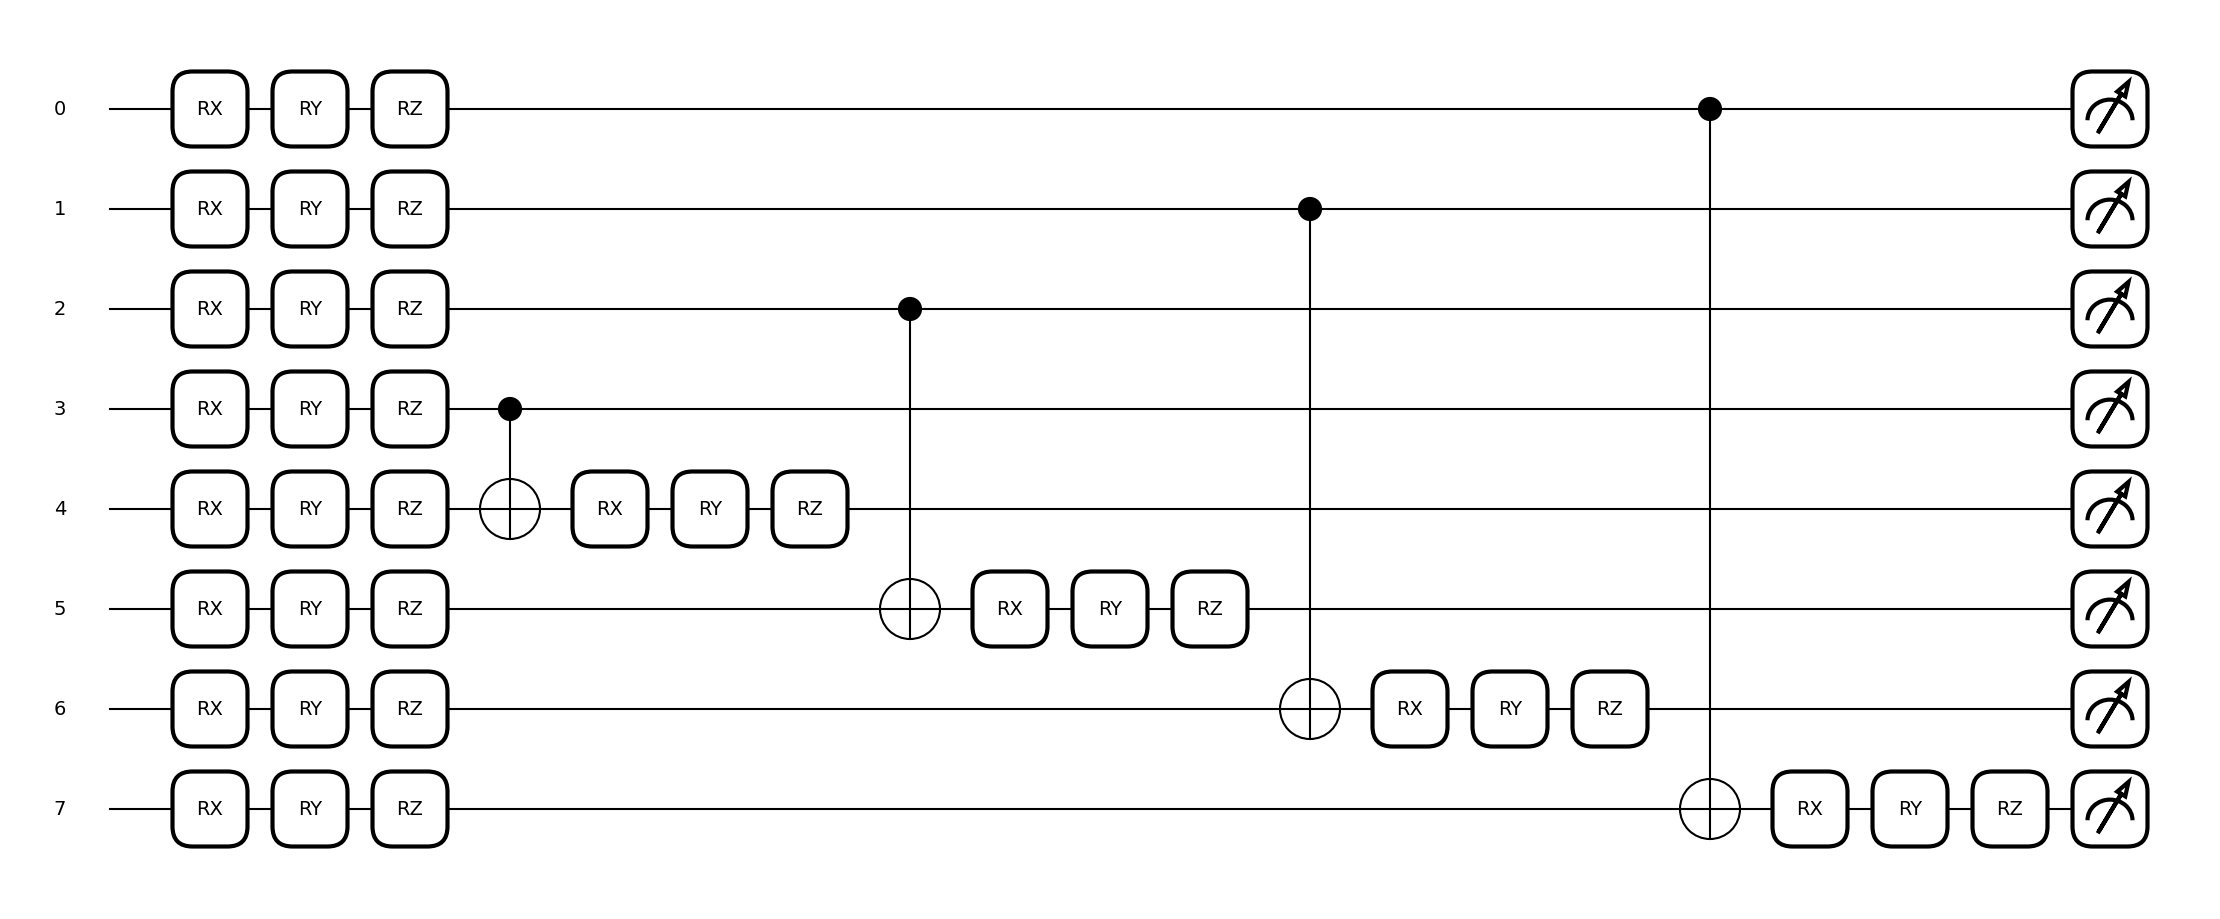

In [9]:
import pennylane as qml
from pennylane import numpy as np


# One-qubit unitary
def one_qubit_unitary(bit, symbols):
    qml.RX(symbols[0], wires=bit)
    qml.RY(symbols[1], wires=bit)
    qml.RZ(symbols[2], wires=bit)

# Two-qubit unitary
def two_qubit_unitary(bits, symbols):
    one_qubit_unitary(bits[0], symbols[0:3])
    one_qubit_unitary(bits[1], symbols[3:6])
    qml.IsingZZ(symbols[6], wires=bits)
    qml.IsingYY(symbols[7], wires=bits)
    qml.IsingXX(symbols[8], wires=bits)
    one_qubit_unitary(bits[0], symbols[9:12])
    one_qubit_unitary(bits[1], symbols[12:])

# Two-qubit pool
def two_qubit_pool(source_qubit, sink_qubit, symbols):
    one_qubit_unitary(sink_qubit, symbols[0:3])
    one_qubit_unitary(source_qubit, symbols[3:6])
    qml.CNOT(wires=[source_qubit, sink_qubit])
    one_qubit_unitary(sink_qubit, symbols[0:3])

def quantum_conv_circuit(bits, symbols):
    for first, second in zip(bits[0::2], bits[1::2]):
        two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        two_qubit_unitary([first, second], symbols)

def quantum_pool_circuit(source_bits, sink_bits, symbols):
    for source, sink in zip(source_bits, sink_bits):
        two_qubit_pool(source, sink, symbols)

n_qubits = 8  # Total number of qubits
source_bits = range(4)[::-1]   # Source qubits are the first 4 qubits
sink_bits = range(4, 8) # Sink qubits are the next 4 qubits
symbols = np.random.random(6)  # Example symbols for the gates

dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def pool_circuit(symbols):
    quantum_pool_circuit(source_bits, sink_bits, symbols)
    return qml.state()

qml.draw_mpl(pool_circuit)(symbols)

The implemented quantum pooling layer pools from N qubits to N/2 qubits. 